# Project Summary

## Business Objective

## Data Options

## Executive Summary

# Data Load & Prep


## Import Libraries


In [2]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set display options to remove scientific notation and allow dataframe rows to display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## Source Dataframes

### Load IMBD Basics

In [10]:
# Load IMDB Basics as title master, set index and convert minutes from float
imdb_basics = pd.read_csv('data/imdb.title.basics.csv')
imdb_basics['runtime_minutes'] = imdb_basics['runtime_minutes'].astype('Int64')
imdb_basics.memory_usage(deep=True).sum()

44533997

### Load IMDB Ratings

In [11]:
# Load IMDB Ratings, set index, standarized column names and convert votes to integer
imdb_ratings = pd.read_csv('data/imdb.title.ratings.csv')
imdb_ratings.rename(columns={'averagerating': "avg_rating", 'numvotes': 'num_votes'}, inplace=True)
imdb_ratings['num_votes'] = imdb_ratings['num_votes'].astype('Int64')
imdb_ratings.memory_usage(deep=True).sum()

6130478

### Load BOM Movie Gross

In [12]:
# Load BOM Movie Gross, transform gross columns from mixed data types into integer
bom = pd.read_csv('data/bom.movie_gross.csv')
bom['domestic_gross'].replace('"', '', inplace=True)
bom['domestic_gross'].fillna(0, inplace=True)
bom['domestic_gross'] = bom['domestic_gross'].astype('Int64')
bom['foreign_gross'] = bom['foreign_gross'].str.replace(',', '')
bom['foreign_gross'].fillna(0, inplace=True)
bom['foreign_gross'] = bom['foreign_gross'].astype('float').round(0).astype('Int64')
bom.head()
bom.memory_usage(deep=True).sum()

541464

### Load TN Movie Budgets

In [13]:
# Load TN Budget, transform gross columns from mixed data types into integer
tn = pd.read_csv('data/tn.movie_budgets.csv')
tn.head()
tn.memory_usage(deep=True).sum()

2028979

In [14]:
# Convert Date and create Year
tn['movie'] = tn['movie'].str.encode('ascii', 'ignore').str.decode('ascii')
tn['release_date'] = pd.to_datetime(tn['release_date'], infer_datetime_format=True).dt.floor('d')
tn['year'] = tn['release_date'].dt.year
currency_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
tn[currency_cols] = tn[currency_cols].apply(lambda x: x.str.replace('$', '').str.replace(',', ''))
tn[currency_cols] = tn[currency_cols].astype('float')
tn.head()

id release_date                                        movie  \
0   1   2009-12-18                                       Avatar   
1   2   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
2   3   2019-06-07                                 Dark Phoenix   
3   4   2015-05-01                      Avengers: Age of Ultron   
4   5   2017-12-15            Star Wars Ep. VIII: The Last Jedi   

   production_budget  domestic_gross  worldwide_gross  year  
0     425,000,000.00  760,507,625.00 2,776,345,279.00  2009  
1     410,600,000.00  241,063,875.00 1,045,663,875.00  2011  
2     350,000,000.00   42,762,350.00   149,762,350.00  2019  
3     330,600,000.00  459,005,868.00 1,403,013,963.00  2015  
4     317,000,000.00  620,181,382.00 1,316,721,747.00  2017

In [15]:
# Clean up duplicate row - single movie found in data profiling
home1 = tn[(tn['movie'] == 'Home') & (tn['release_date'] == '2009-04-23')] #more complete record
home2 = tn[(tn['movie'] == 'Home') & (tn['release_date'] == '2009-06-05')] #contains budget $12m
home2_budget = home2['production_budget'].sum()
home1['production_budget'] = home1['production_budget'] + home2_budget

# Update/drop duplicate
tn.drop(home2.index, inplace = True)
tn.update(home1)

#Validation
display(tn[(tn['movie'] == 'Home') ])
tn.head()

<ipython-input-15-5b78ee3ab015>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home1['production_budget'] = home1['production_budget'] + home2_budget


id release_date movie  production_budget  domestic_gross  \
243  44.00   2015-03-27  Home     130,000,000.00  177,397,510.00   
5459 60.00   2009-04-23  Home      12,500,000.00       15,433.00   

      worldwide_gross     year  
243    385,997,896.00 2,015.00  
5459    44,793,168.00 2,009.00

id release_date                                        movie  \
0 1.00   2009-12-18                                       Avatar   
1 2.00   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
2 3.00   2019-06-07                                 Dark Phoenix   
3 4.00   2015-05-01                      Avengers: Age of Ultron   
4 5.00   2017-12-15            Star Wars Ep. VIII: The Last Jedi   

   production_budget  domestic_gross  worldwide_gross     year  
0     425,000,000.00  760,507,625.00 2,776,345,279.00 2,009.00  
1     410,600,000.00  241,063,875.00 1,045,663,875.00 2,011.00  
2     350,000,000.00   42,762,350.00   149,762,350.00 2,019.00  
3     330,600,000.00  459,005,868.00 1,403,013,963.00 2,015.00  
4     317,000,000.00  620,181,382.00 1,316,721,747.00 2,017.00

In [16]:
# Transform some columns
tn['worldwide_profit'] = tn['worldwide_gross'] - tn['production_budget']
tn['profit_margin'] = (tn['worldwide_profit'] / tn['production_budget'])*100
tn['is_profitable'] = tn['worldwide_profit'] > 0
tn.head()

id release_date                                        movie  \
0 1.00   2009-12-18                                       Avatar   
1 2.00   2011-05-20  Pirates of the Caribbean: On Stranger Tides   
2 3.00   2019-06-07                                 Dark Phoenix   
3 4.00   2015-05-01                      Avengers: Age of Ultron   
4 5.00   2017-12-15            Star Wars Ep. VIII: The Last Jedi   

   production_budget  domestic_gross  worldwide_gross     year  \
0     425,000,000.00  760,507,625.00 2,776,345,279.00 2,009.00   
1     410,600,000.00  241,063,875.00 1,045,663,875.00 2,011.00   
2     350,000,000.00   42,762,350.00   149,762,350.00 2,019.00   
3     330,600,000.00  459,005,868.00 1,403,013,963.00 2,015.00   
4     317,000,000.00  620,181,382.00 1,316,721,747.00 2,017.00   

   worldwide_profit  profit_margin  is_profitable  
0  2,351,345,279.00         553.26           True  
1    635,063,875.00         154.67           True  
2   -200,237,650.00         -57.21          False  
3  1,072,413,963.00         324.38           True  
4    999,721,747.00         315.37           True

### Load IMDB Principals

In [27]:
# Load IMBD Principals, transform gross columns from mixed data types into integer
prin = pd.read_csv('data/imdb.title.principals.csv', usecols=['tconst','nconst','category'])
prin = prin[prin['category']=='actor']
prin.head()
len(prin)

256718

### Load IMBD Name Basics

In [28]:
# Load IMBD Name Basics, transform gross columns from mixed data types into integer
peop = pd.read_csv('data/imdb.name.basics.csv', usecols=['nconst','primary_name'])
len(peop)

606648

In [29]:
# Create dataframe for Principals
prin = prin.merge(peop, how='inner', left_on='nconst', right_on='nconst', indicator='peop_ind')
del peop
prin.memory_usage(deep=True).sum()

70534900

In [30]:
movies_slim = movies[ (movies['start_year'].between(2010,2019)) & (movies['gross_ind']=='both') ]
prin = prin.merge(movies_slim, how='inner', left_on='tconst', right_on='tconst', indicator='mov_ind')
prin['ww_gross'] = prin['domestic_gross_x'] + prin['foreign_gross']
prin.head()
prin.memory_usage(deep=True).sum()

4586372

In [53]:
prin['peop_ind'].value_counts()
prin['mov_ind'].value_counts()

both          1016145
left_only       12060
right_only          0
Name: mov_ind, dtype: int64

In [62]:
top = prin.groupby('primary_name', as_index=False).agg(movie_count = ('title_cnt', 'sum'), 
                                                        domestic_gross = ('domestic_gross_x',  'sum'),
                                                        foreign_gross = ('foreign_gross', 'sum'),
                                                        ww_gross = ('ww_gross', 'sum')
                                                       ).sort_values('movie_count', ascending=False)
top['ww_gross_per_movie'] = top['ww_gross'] / top['movie_count']
top = top.sort_values(['ww_gross'], ascending=False)

## Data Profiling

### IMDB Basics Checks

In [10]:
# IMDB Basics import and data quality check

print(imdb_basics.head(2))
imdb_basics.info() # Nulls 31K minutes, 5K genre
imdb_basics['start_year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
imdb_basics['genres'].value_counts(sort=True) #Majority single genres but 1085 combinations

      tconst                    primary_title   original_title  start_year  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   runtime_minutes              genres  
0              175  Action,Crime,Drama  
1              114     Biography,Drama  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           146144 non-null  object
 1   primary_title    146144 non-null  object
 2   original_title   146123 non-null  object
 3   start_year       146144 non-null  int64 
 4   runtime_minutes  114405 non-null  Int64 
 5   genres           140736 non-null  object
dtypes: Int64(1), int64(1), object(4)
memory usage: 6.8+ MB


Documentary                         32185
Drama                               21486
Comedy                               9177
Horror                               4372
Comedy,Drama                         3519
Thriller                             3046
Action                               2219
Biography,Documentary                2115
Drama,Romance                        2079
Comedy,Drama,Romance                 1558
Documentary,Drama                    1554
Comedy,Romance                       1507
Romance                              1454
Documentary,Music                    1365
Drama,Thriller                       1335
Documentary,History                  1289
Horror,Thriller                      1253
Biography,Documentary,History        1230
Biography,Documentary,Drama          1028
Family                                939
Animation                             828
Drama,Family                          784
Action,Crime,Drama                    727
Comedy,Horror                     

In [198]:
imdb_basics.duplicated(['tconst'],keep=False).sum() #No dups
imdb_basics.duplicated(['primary_title','start_year'],keep=False).sum() #3942 dups


3942

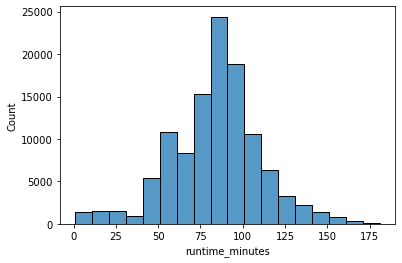

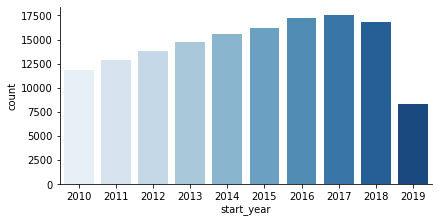

In [11]:
# Review distribution plots
length180 = imdb_basics[imdb_basics['runtime_minutes'] < 180]
sns.histplot(data=length180, x='runtime_minutes', binwidth=10, palette='Blues')

keepyears = imdb_basics[imdb_basics['start_year'].between(2010,2019)]
sns.catplot(data=keepyears, kind='count', x='start_year', palette='Blues', height=3, aspect=2)


### IMDB Ratings Checks

In [12]:
# 
imdb_ratings.head()
imdb_ratings.info()
imdb_ratings.duplicated(['tconst'],keep=False).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tconst      73856 non-null  object 
 1   avg_rating  73856 non-null  float64
 2   num_votes   73856 non-null  Int64  
dtypes: Int64(1), float64(1), object(1)
memory usage: 1.8+ MB


0

### BOM Movie Gross Checks

In [13]:
# BOM Movie Gross File - explore data quality
print(bom.head(2))
print(bom.info()) # Nulls 31K minutes, 5K genre
print(bom.describe())
bom['year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
bom['studio'].value_counts(sort=True) #Majority single genres but 1085 combinations

                        title studio  domestic_gross  foreign_gross  year
0                 Toy Story 3     BV       415000000      652000000  2010
1  Alice in Wonderland (2010)     BV       334200000      691300000  2010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           3387 non-null   object
 1   studio          3382 non-null   object
 2   domestic_gross  3387 non-null   Int64 
 3   foreign_gross   3387 non-null   Int64 
 4   year            3387 non-null   int64 
dtypes: Int64(2), int64(1), object(2)
memory usage: 139.0+ KB
None
       domestic_gross  foreign_gross     year
count        3,387.00       3,387.00 3,387.00
mean    28,508,205.96  45,029,794.59 2,013.96
std     66,755,749.11 112,684,345.89     2.48
min              0.00           0.00 2,010.00
25%        111,500.00           0.00 2,012.00
50%      1,300,000.00

IFC             166
Uni.            147
WB              140
Fox             136
Magn.           136
SPC             123
Sony            110
BV              106
LGF             103
Par.            101
Eros             89
Wein.            77
CL               74
Strand           68
FoxS             67
RAtt.            66
KL               62
Focus            60
WGUSA            58
CJ               56
MBox             54
UTV              50
A24              49
WB (NL)          45
FM               42
LG/S             41
Cohen            40
ORF              37
Rela.            35
SGem             35
FIP              26
Gold.            24
STX              24
GK               24
TriS             23
Osci.            23
RTWC             23
MNE              22
BST              22
EOne             21
Drft.            20
Distrib.         20
Anch.            18
Relbig.          18
CBS              17
Zeit.            16
BG               16
Sum.             15
W/Dim.           14
Trib.            14


In [14]:
print(f"\n**{bom.duplicated(['title'],keep=False).sum()} duplicates found based on title**\n") #No dups
print(f"\n**{bom.duplicated(['title'],keep=False)} duplicates found based on title**\n") #No dups


**2 duplicates found based on title**


**0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64      False
65      False
66      False
67      False
68   

### TN Movie Budgets Checks

In [15]:
# TN Budgets File - explore data quality
display(tn.head(2))
display(tn.info()) # Nulls 31K minutes, 5K genre
print(tn.describe())
tn.groupby(by='year').sum().sort_values(by='year', ascending=False).head(10) #Consistent data through 2016 then drop

tn.duplicated(['movie','year'],keep=False).sum()
tn[tn.duplicated(['movie','year'],keep=False)]

id release_date                                        movie  \
0   1   2009-12-18                                       Avatar   
1   2   2011-05-20  Pirates of the Caribbean: On Stranger Tides   

   production_budget  domestic_gross  worldwide_gross  year  worldwide_profit  \
0     425,000,000.00  760,507,625.00 2,776,345,279.00  2009  2,351,345,279.00   
1     410,600,000.00  241,063,875.00 1,045,663,875.00  2011    635,063,875.00   

   profit_margin  is_profitable  
0         553.26           True  
1         154.67           True

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
 6   year               5782 non-null   int64         
 7   worldwide_profit   5782 non-null   float64       
 8   profit_margin      5782 non-null   float64       
 9   is_profitable      5782 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 412.3+ KB


None

            id  production_budget  domestic_gross  worldwide_gross     year  \
count 5,782.00           5,782.00        5,782.00         5,782.00 5,782.00   
mean     50.37      31,587,757.10   41,873,326.87    91,487,460.91 2,003.97   
std      28.82      41,812,076.83   68,240,597.36   174,719,968.78    12.72   
min       1.00           1,100.00            0.00             0.00 1,915.00   
25%      25.00       5,000,000.00    1,429,534.50     4,125,414.75 2,000.00   
50%      50.00      17,000,000.00   17,225,945.00    27,984,448.50 2,007.00   
75%      75.00      40,000,000.00   52,348,661.50    97,645,836.50 2,012.00   
max     100.00     425,000,000.00  936,662,225.00 2,776,345,279.00 2,020.00   

       worldwide_profit  profit_margin  
count          5,782.00       5,782.00  
mean      59,899,703.81         380.02  
std      146,088,881.08       2,953.03  
min     -200,237,650.00        -100.00  
25%       -2,189,070.75         -50.77  
50%        8,550,285.50          70.83  
7

id release_date movie  production_budget  domestic_gross  \
3455  56   2009-06-05  Home      12,000,000.00            0.00   
5459  60   2009-04-23  Home         500,000.00       15,433.00   

      worldwide_gross  year  worldwide_profit  profit_margin  is_profitable  
3455             0.00  2009    -12,000,000.00        -100.00          False  
5459    44,793,168.00  2009     44,293,168.00       8,858.63           True

# Feature Engineering

## Create Movies Dataframe

### Join IMDB Basics + Ratings

In [17]:
# Create Movies DF - basics left join to ratings and bom 
movies = imdb_basics.merge(imdb_ratings, how='left', left_on='tconst', right_on='tconst', indicator='rating_ind')
movies.drop(columns=['original_title'], inplace=True)
movies['rating_sum'] = movies['num_votes'] * movies['avg_rating']
movies.head()

tconst                    primary_title  start_year  runtime_minutes  \
0  tt0063540                        Sunghursh        2013              175   
1  tt0066787  One Day Before the Rainy Season        2019              114   
2  tt0069049       The Other Side of the Wind        2018              122   
3  tt0069204                  Sabse Bada Sukh        2018             <NA>   
4  tt0100275         The Wandering Soap Opera        2017               80   

                 genres  avg_rating  num_votes rating_ind  rating_sum  
0    Action,Crime,Drama        7.00         77       both      539.00  
1       Biography,Drama        7.20         43       both      309.60  
2                 Drama        6.90       4517       both   31,167.30  
3          Comedy,Drama        6.10         13       both       79.30  
4  Comedy,Drama,Fantasy        6.50        119       both      773.50

### Deduplicate Movie Titles

In [18]:
#movies.duplicated(['primary_title','start_year'],keep=False).sum() #3942 dups
dups = movies[movies.duplicated(subset=['primary_title','start_year'],keep=False)]
dups.sort_values(['primary_title','start_year','num_votes','runtime_minutes'], ascending=[True, True, True, True], na_position='first', inplace=True)
dups_remove = dups[dups.duplicated(subset=['primary_title','start_year'],keep='last') == True]
dups_keep = dups[dups.duplicated(subset=['primary_title','start_year'],keep='last') == False]
movies.drop(dups_remove.index, inplace = True)

#Validations
display(dups_keep.duplicated(['primary_title','start_year'],keep=False).sum())
display(movies.duplicated(['primary_title','start_year'], keep=False).sum()) #0 dups
movies[movies['primary_title']=='Alice in Wonderland']

<ipython-input-18-06e5d8b5a5f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups.sort_values(['primary_title','start_year','num_votes','runtime_minutes'], ascending=[True, True, True, True], na_position='first', inplace=True)


0

0

tconst        primary_title  start_year  runtime_minutes  \
1608   tt1014759  Alice in Wonderland        2010              108   
22538  tt1926979  Alice in Wonderland        2011               48   

                         genres  avg_rating  num_votes rating_ind   rating_sum  
1608   Adventure,Family,Fantasy        6.50     358813       both 2,332,284.50  
22538               Documentary         nan       <NA>  left_only          nan

### Merge BOM Movie Gross

In [19]:
movies = movies.merge(bom, how='left', left_on='primary_title', right_on='title', indicator='gross_ind')
movies.drop(columns=['title','year'], inplace=True)
movies['title_cnt'] = 1

In [170]:
movies[movies['gross_ind']=='both'].head(100)

tconst                        primary_title  start_year  \
38   tt0315642                                Wazir        2016   
48   tt0337692                          On the Road        2012   
54   tt0359950      The Secret Life of Walter Mitty        2013   
58   tt0365907          A Walk Among the Tombstones        2014   
60   tt0369610                       Jurassic World        2015   
61   tt0372538                                  Spy        2011   
62   tt0376136                        The Rum Diary        2011   
63   tt0376479                    American Pastoral        2016   
67   tt0383010                    The Three Stooges        2012   
71   tt0398286                              Tangled        2010   
73   tt0401729                          John Carter        2012   
74   tt0402887                     Capture the Flag        2010   
80   tt0409379                            In Secret        2013   
81   tt0409847                     Cowboys & Aliens        2011   
85   tt0419692                           Disconnect        2010   
86   tt0420293       The Stanford Prison Experiment        2015   
92   tt0427152                  Dinner for Schmucks        2010   
95   tt0429493                           The A-Team        2010   
97   tt0431021                       The Possession        2012   
99   tt0433035                           Real Steel        2011   
103  tt0435651                            The Giver        2014   
104  tt0435761                          Toy Story 3        2010   
115  tt0443272                              Lincoln        2012   
117  tt0443465                         Before We Go        2014   
121  tt0446029          Scott Pilgrim vs. the World        2010   
126  tt0448694                        Puss in Boots        2011   
131  tt0451279                         Wonder Woman        2017   
136  tt0454876                           Life of Pi        2012   
137  tt0455323                          Being Flynn        2012   
138  tt0455407                          The Crazies        2010   
139  tt0455944                        The Equalizer        2014   
141  tt0458339   Captain America: The First Avenger        2011   
142  tt0458413                      A Long Way Down        2014   
148  tt0460890      The Only Living Boy in New York        2017   
150  tt0461336                 Saving Private Perez        2011   
152  tt0462335                            High-Rise        2015   
159  tt0464154                           Piranha 3D        2010   
165  tt0466893                             Margaret        2011   
170  tt0470752                           Ex Machina        2014   
172  tt0471042                          Tower Heist        2011   
173  tt0472181                           The Smurfs        2011   
174  tt0472399                         The Mechanic        2011   
176  tt0473075  Prince of Persia: The Sands of Time        2010   
181  tt0475290                        Hail, Caesar!        2016   
185  tt0477080                          Unstoppable        2010   
187  tt0477302    Extremely Loud & Incredibly Close        2011   
188  tt0478304                     The Tree of Life        2011   
190  tt0478970                              Ant-Man        2015   
194  tt0479997                  Season of the Witch        2011   
196  tt0480255                           The Losers        2010   
197  tt0480687                            Hall Pass        2011   
199  tt0481499                           The Croods        2013   
209  tt0485985                            Red Tails        2012   
216  tt0491152                   Something Borrowed        2011   
217  tt0491175                           Suburbicon        2017   
218  tt0491203                          Tulip Fever        2017   
219  tt0492389                      Furry Vengeance        2010   
222  tt0493949                    Ramona and Beezus        2010   
227  tt0498351               The Hero of Color City    

In [17]:
movies.groupby(['rating_ind','gross_ind']).size() # 98% have ratings, less than 5% have gross sales


rating_ind  gross_ind 
left_only   left_only     70537
            right_only        0
            both            264
right_only  left_only         0
            right_only        0
            both              0
both        left_only     70315
            right_only        0
            both           2958
dtype: int64

### Merge TN Movie Budgets

In [20]:
print(f'Note: TN file has {tn.movie.size} unique titles. IMDB Basics has {movies.primary_title.size}.')

keep = ['movie','year','production_budget','domestic_gross','worldwide_gross','worldwide_profit','profit_margin','is_profitable']
l_keys = ['start_year', 'primary_title']
r_keys = ['year','movie']
movies = movies.merge(tn[keep], how='left', left_on=l_keys, right_on=r_keys, indicator='tn_ind')
movies.drop(columns=['movie','year'], inplace=True)
movies['gross_per_rating'] =  movies['worldwide_gross'] / movies['rating_sum']


Note: TN file has 5781 unique titles. IMDB Basics has 144074.


In [21]:
movies.memory_usage(deep=True).sum()

58198336

### Reverse Match TN Movie Budgets

In [19]:
movies[movies['tn_ind']=='both'].head(10)

tconst                    primary_title  start_year  runtime_minutes  \
20  tt0249516                       Foodfight!        2012               91   
54  tt0359950  The Secret Life of Walter Mitty        2013              114   
58  tt0365907      A Walk Among the Tombstones        2014              114   
60  tt0369610                   Jurassic World        2015              124   
62  tt0376136                    The Rum Diary        2011              119   
67  tt0383010                The Three Stooges        2012               92   
69  tt0393049                 Anderson's Cross        2010               98   
71  tt0398286                          Tangled        2010              100   
73  tt0401729                      John Carter        2012              132   
92  tt0427152              Dinner for Schmucks        2010              114   

                        genres  avg_rating  num_votes rating_ind   rating_sum  \
20     Action,Animation,Comedy        1.90       8248       both    15,671.20   
54      Adventure,Comedy,Drama        7.30     275300       both 2,009,690.00   
58          Action,Crime,Drama        6.50     105116       both   683,254.00   
60     Action,Adventure,Sci-Fi        7.00     539338       both 3,775,366.00   
62                Comedy,Drama        6.20      94787       both   587,679.40   
67               Comedy,Family        5.10      28570       both   145,707.00   
69        Comedy,Drama,Romance        5.50        106       both       583.00   
71  Adventure,Animation,Comedy        7.80     366366       both 2,857,654.80   
73     Action,Adventure,Sci-Fi        6.60     241792       both 1,595,827.20   
92                      Comedy        5.90      91546       both   540,121.40   

   studio  domestic_gross_x  foreign_gross  gross_ind  title_cnt  \
20    NaN              <NA>           <NA>  left_only          1   
54    Fox          58200000      129900000       both          1   
58   Uni.          26300000       26900000       both          1   
60   Uni.         652300000           1019       both          1   
62     FD          13100000       10800000       both          1   
67    Fox          44300000       10500000       both          1   
69    NaN              <NA>           <NA>  left_only          1   
71     BV         200800000      391000000       both          1   
73     BV          73100000      211100000       both          1   
92   P/DW          73000000       13800000       both          1   

    production_budget  domestic_gross_y  worldwide_gross  worldwide_profit  \
20      45,000,000.00              0.00        73,706.00    -44,926,294.00   
54      91,000,000.00     58,236,838.00   187,861,183.00     96,861,183.00   
58      28,000,000.00     26,017,685.00    62,108,587.00     34,108,587.00   
60     215,000,000.00    652,270,625.00 1,648,854,864.00  1,433,854,864.00   
62      45,000,000.00     13,109,815.00    21,544,732.00    -23,455,268.00   
67      30,000,000.00     44,338,224.00    54,052,249.00     24,052,249.00   
69         300,000.00              0.00             0.00       -300,000.00   
71     260,000,000.00    200,821,936.00   586,477,240.00    326,477,240.00   
73     275,000,000.00     73,058,679.00   282,778,100.00      7,778,100.00   
92      69,000,000.00     73,026,337.00    86,796,502.00     17,796,502.00   

    profit_margin is_profitable tn_ind  gross_per_rating  
20         -99.84         False   both              4.70  
54         106.44          True   both             93.48  
58         121.82          True   both             90.90  
60         666.91          True   both            436.74  
62         -52.12         False   both             36.66  
67          80.17          True   both            370.97  
69        -100.00         False   both              0.00  
71         125.57          True   both            205.23  
73           2.83          True   both            177.20  
92          25.79          True   both         

In [20]:
display(movies['tn_ind'].value_counts())

keep = ['primary_title','start_year','tn_ind']
r_keys = ['start_year', 'primary_title']
l_keys = ['year','movie']
tn_reverse = tn.merge(movies[keep], how='left', left_on=l_keys, right_on=r_keys, indicator='movies_ind')

display(tn_reverse['movies_ind'].value_counts())
tn_reverse[tn_reverse['year']>=2010].groupby(['year']).size()

table = pd.pivot_table(tn_reverse[tn_reverse['year']>=2010], values='movie', index='year', columns='movies_ind', aggfunc='count')
table.head(10)

tn_reverse[tn_reverse['movies_ind']=='left_only']
#tn_reverse[tn_reverse['movies_ind']=='both']

left_only     142590
both            1484
right_only         0
Name: tn_ind, dtype: int64

left_only     4298
both          1484
right_only       0
Name: movies_ind, dtype: int64

id release_date                                              movie  \
0       1   2009-12-18                                             Avatar   
4       5   2017-12-15                  Star Wars Ep. VIII: The Last Jedi   
5       6   2015-12-18               Star Wars Ep. VII: The Force Awakens   
7       8   2007-05-24            Pirates of the Caribbean: At Worlds End   
15     16   2007-05-04                                       Spider-Man 3   
19     20   2009-07-15             Harry Potter and the Half-Blood Prince   
23     24   2006-06-28                                   Superman Returns   
25     26   2008-11-14                                  Quantum of Solace   
27     28   2006-07-07          Pirates of the Caribbean: Dead Mans Chest   
29     30   2008-05-16           The Chronicles of Narnia: Prince Caspian   
35     36   2009-06-24                Transformers: Revenge of the Fallen   
37     38   2006-05-26                              X-Men: The Last Stand   
39     40   2005-12-14                                          King Kong   
40     41   2007-12-07                                 The Golden Compass   
42     43   1997-12-19                                            Titanic   
48     49   2017-05-05                      Guardians of the Galaxy Vol 2   
49     50   2004-06-30                                       Spider-Man 2   
57     58   2010-12-17                                       Tron: Legacy   
58     59   2009-11-13                                               2012   
60     61   2009-05-21                               Terminator Salvation   
62     63   2010-05-28                    Prince of Persia: Sands of Time   
70     71   2009-11-06                          Disneys A Christmas Carol   
73     74   2008-05-02                                           Iron Man   
74     75   2008-07-18                                    The Dark Knight   
75     76   2008-05-22  Indiana Jones and the Kingdom of the Crystal S...   
82     83   2005-12-09  The Chronicles of Narnia: The Lion, the Witch ...   
85     86   2008-06-27                                             WALL-E   
86     87   2007-08-10                                        Rush Hour 3   
91     92   2018-07-27                         Mission: ImpossibleFallout   
100     1   2009-05-29                                                 Up   
102     3   2018-11-21                          Ralph Breaks The Internet   
103     4   2009-03-27                                Monsters vs. Aliens   
105     6   2009-08-07                        G.I. Joe: The Rise of Cobra   
106     7   1999-06-30                                     Wild Wild West   
107     8   2008-08-01              The Mummy: Tomb of the Dragon Emperor   
108     9   2007-06-22                                      Evan Almighty   
109    10   1995-07-28                                         Waterworld   
117    18   2004-11-10                                  The Polar Express   
119    20   2003-07-01                 Terminator 3: Rise of the Machines   
120    21   2004-05-07                                        Van Helsing   
133    34   2011-07-29                                 Cowboys and Aliens   
136    37   2007-05-17                                    Shrek the Third   
139    40   2013-05-24                                 Fast and Furious 6   
142    43   2008-12-25                The Curious Case of Benjamin Button   
144    45   2006-05-12                                           Poseidon   
148    49   2015-07-01                                Terminator: Genisys   
150    51   2004-11-24                                          Alexander   
152    53   2001-05-25                                       Pearl Harbor   
153    54   2007-07-02                                       Transformers   
157    58   2007-07-11          Harry Potter and the Order of the Phoenix   
158    59   2005-11-18                Harry Potter and the Goblet of Fire   
159

## Featurize Genres

In [23]:
# Concatenate non-null genres series strings together in unique list
genres_list = ','.join(str(x) for x in imdb_basics['genres'].dropna().unique())
# Split genres list into unique set of genres
genres_unique = set(x for x in genres_list.split(','))

# Loop unique genres, create new boolean series for each genre; useful for correlations
for genre in sorted(genres_unique):
    movies['is_'+genre.lower()] = movies.apply(lambda x: int(genre in str(x.genres)), axis=1)

movies.head()

tconst                    primary_title  start_year  runtime_minutes  \
0  tt0063540                        Sunghursh        2013              175   
1  tt0066787  One Day Before the Rainy Season        2019              114   
2  tt0069049       The Other Side of the Wind        2018              122   
3  tt0069204                  Sabse Bada Sukh        2018             <NA>   
4  tt0100275         The Wandering Soap Opera        2017               80   

                 genres  avg_rating  num_votes rating_ind  rating_sum studio  \
0    Action,Crime,Drama        7.00         77       both      539.00    NaN   
1       Biography,Drama        7.20         43       both      309.60    NaN   
2                 Drama        6.90       4517       both   31,167.30    NaN   
3          Comedy,Drama        6.10         13       both       79.30    NaN   
4  Comedy,Drama,Fantasy        6.50        119       both      773.50    NaN   

   domestic_gross_x  foreign_gross  gross_ind  title_cnt  production_budget  \
0              <NA>           <NA>  left_only          1                nan   
1              <NA>           <NA>  left_only          1                nan   
2              <NA>           <NA>  left_only          1                nan   
3              <NA>           <NA>  left_only          1                nan   
4              <NA>           <NA>  left_only          1                nan   

   domestic_gross_y  worldwide_gross  worldwide_profit  profit_margin  \
0               nan              nan               nan            nan   
1               nan              nan               nan            nan   
2               nan              nan               nan            nan   
3               nan              nan               nan            nan   
4               nan              nan               nan            nan   

  is_profitable     tn_ind  gross_per_rating  is_action  is_adult  \
0           NaN  left_only               nan          1         0   
1           NaN  left_only               nan          0         0   
2           NaN  left_only               nan          0         0   
3           NaN  left_only               nan          0         0   
4           NaN  left_only               nan          0         0   

   is_adventure  is_animation  is_biography  is_comedy  is_crime  \
0             0             0             0          0         1   
1             0             0             1          0         0   
2             0             0             0          0         0   
3             0             0             0          1         0   
4             0             0             0          1         0   

   is_documentary  is_drama  is_family  is_fantasy  is_game-show  is_history  \
0               0         1          0           0             0           0   
1               0         1          0           0             0           0   
2               0         1          0           0             0           0   
3               0         1          0           0             0           0   
4               0         1          0           1             0           0   

   is_horror  is_music  is_musical  is_mystery  is_news  is_reality-tv  \
0          0         0           0           0        0              0   
1          0         0           0           0        0              0   
2          0         0           0           0        0              0   
3          0         0           0           0        0              0   
4          0         0           0           0        0              0   

   is_romance  is_sci-fi  is_short  is_sport  is_talk-show  is_thriller  \
0           0          0         0         0             0            0   
1           0          0         0         0             0            0   
2           0          0         0         0             0            0   
3           0          0         0         0             0            0   
4           0    

# Business Analysis

## Genre Counts & Ratings

Profits = Worldwide Sales - Production Costs
Profit Margins = Profits / Production Costs
Notes: Sales and costs are adjusted by CPI factor, limited data sets have this data.

### Group By Genres

In [21]:
# Top movie genres 2010-2019
year_filter = movies['start_year'].between(2010,2019)
titles = movies[year_filter].groupby('genres', as_index=False).agg(Movie_Count = ('title_cnt', 'sum')).sort_values('Movie_Count', ascending=False)[:20]
titles['Subtotal'] = movies[year_filter].title_cnt.sum()
titles['Pct_Total'] = (titles['Movie_Count']*100 / titles['Subtotal'])
print(titles)


                             genres  Movie_Count  Subtotal  Pct_Total
693                     Documentary        31797    143026      22.23
792                           Drama        20896    143026      14.61
493                          Comedy         9016    143026       6.30
989                          Horror         4254    143026       2.97
526                    Comedy,Drama         3455    143026       2.42
1075                       Thriller         2894    143026       2.02
0                            Action         2124    143026       1.49
432           Biography,Documentary         2087    143026       1.46
870                   Drama,Romance         2038    143026       1.42
536            Comedy,Drama,Romance         1545    143026       1.08
694               Documentary,Drama         1525    143026       1.07
607                  Comedy,Romance         1492    143026       1.04
1058                        Romance         1413    143026       0.99
750               Do

[Text(0.5, 1.0, 'Movies By Genre Type 2010 through 2019')]

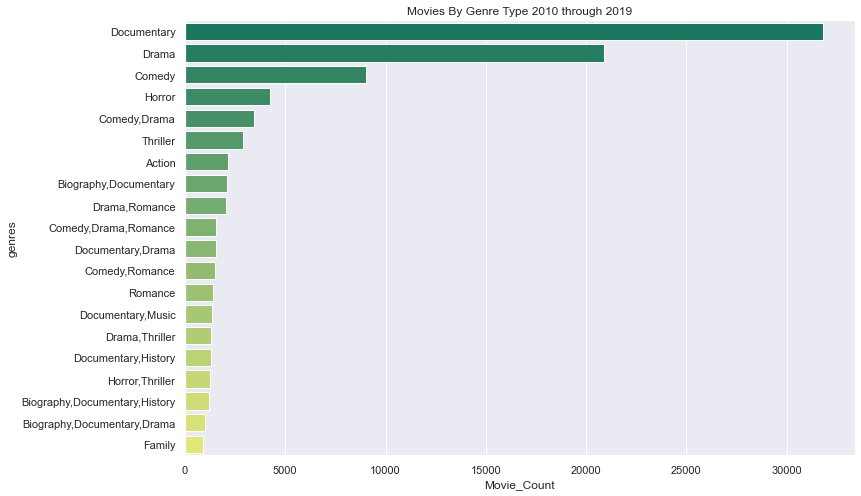

In [25]:
# Plot the top 20 genres by title count from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax = sns.barplot(data = titles, orient='h', x = 'Movie_Count', y = 'genres', palette='summer')
ax.set(title='Movies By Genre Type 2010 through 2019') # title barplot

### Group By Unique Genre

In [26]:
# Top dervied movie genres 2010-2019
g_cnt_der = movies[['tconst', 'primary_title', 'start_year', 'genres', 'title_cnt', 'runtime_minutes', 'rating_ind', 
                    'avg_rating', 'num_votes', 'rating_sum', 'gross_per_rating', 'tn_ind', 'production_budget', 'domestic_gross_y', 
                    'worldwide_gross', 'worldwide_profit', 'profit_margin', 'is_profitable']]

g_cnt_der['genres'] = g_cnt_der['genres'].str.split(',')
g_cnt_der['num_genres'] = g_cnt_der['genres'].str.len()
g_cnt_der = g_cnt_der.explode('genres')
g_cnt_der['title_cnt_der'] = g_cnt_der['title_cnt'] / g_cnt_der['num_genres']
genre_suppress = ['Reality-TV','Talk-Show','Adult','Short','Game-Show','War','Horror','Western','News','Musical','Documentary']
g_cnt_der = g_cnt_der[(g_cnt_der.start_year.between(2010,2019)) & (~g_cnt_der.genres.isin(genre_suppress))]
supergenre_dict = {'Action':'Special', 'Sci-Fi':'Special','Thriller':'Special','Mystery':'Special',
                   'Adventure':'Special','Fantasy':'Special','Animation':'Traditional','Family':'Traditional',
                   'Comedy':'Traditional','Drama':'Traditional','Crime':'Traditional','Romance':'Traditional',
                   'Music':'Reference','Documentary':'Reference','Sport':'Reference','History':'Reference',
                   'Biography':'Reference'}
g_cnt_der['super_genre']= g_cnt_der['genres'].map(supergenre_dict)

g_cnt_der.head()


<ipython-input-26-c04d28829ec2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_cnt_der['genres'] = g_cnt_der['genres'].str.split(',')
<ipython-input-26-c04d28829ec2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_cnt_der['num_genres'] = g_cnt_der['genres'].str.len()


tconst                    primary_title  start_year     genres  \
0  tt0063540                        Sunghursh        2013     Action   
0  tt0063540                        Sunghursh        2013      Crime   
0  tt0063540                        Sunghursh        2013      Drama   
1  tt0066787  One Day Before the Rainy Season        2019  Biography   
1  tt0066787  One Day Before the Rainy Season        2019      Drama   

   title_cnt  runtime_minutes rating_ind  avg_rating  num_votes  rating_sum  \
0          1              175       both        7.00         77      539.00   
0          1              175       both        7.00         77      539.00   
0          1              175       both        7.00         77      539.00   
1          1              114       both        7.20         43      309.60   
1          1              114       both        7.20         43      309.60   

   gross_per_rating     tn_ind  production_budget  domestic_gross_y  \
0               nan  left_only                nan               nan   
0               nan  left_only                nan               nan   
0               nan  left_only                nan               nan   
1               nan  left_only                nan               nan   
1               nan  left_only                nan               nan   

   worldwide_gross  worldwide_profit  profit_margin is_profitable  num_genres  \
0              nan               nan            nan           NaN        3.00   
0              nan               nan            nan           NaN        3.00   
0              nan               nan            nan           NaN        3.00   
1              nan               nan            nan           NaN        2.00   
1              nan               nan            nan           NaN        2.00   

   title_cnt_der  super_genre  
0           0.33      Special  
0           0.33  Traditional  
0           0.33  Traditional  
1           0.50    Reference  
1           0.50  Traditional

In [27]:
titles_der = g_cnt_der.groupby('genres', as_index=False).agg(movie_count = ('title_cnt_der', 'sum'), avg_runtime_mins = ('runtime_minutes', 'mean'), avg_rating_avg = ('avg_rating', 'mean'), num_votes_avg = ('num_votes', 'mean')).sort_values('movie_count', ascending=False)
titles_der['total_movies'] = titles_der['movie_count'].sum()
titles_der['pct_total'] = (titles_der['movie_count']*100 / titles_der['total_movies'])
titles_der

genres  movie_count  avg_runtime_mins  avg_rating_avg  num_votes_avg  \
6       Drama    32,312.83             94.40            6.40       3,922.18   
4      Comedy    15,625.67             93.95            6.00       4,315.90   
15   Thriller     6,410.83             94.45            5.64       5,923.99   
0      Action     5,110.00            100.12            5.81      14,573.83   
12    Romance     4,664.00            100.30            6.15       4,114.67   
3   Biography     3,615.17             74.28            7.16       5,699.92   
7      Family     2,948.00             83.32            6.39       2,551.15   
5       Crime     2,915.17             95.62            6.11       8,662.39   
9     History     2,611.83             78.89            7.04       2,786.10   
1   Adventure     2,602.00             85.86            6.19      22,177.42   
10      Music     2,169.83             82.41            7.09       2,786.17   
11    Mystery     2,001.83             93.37            5.92       8,202.89   
13     Sci-Fi     1,672.17             90.68            5.49      19,632.28   
8     Fantasy     1,554.83             91.99            5.92      12,457.27   
2   Animation     1,504.50             80.83            6.25       8,828.78   
14      Sport     1,133.33             81.10            6.97       3,200.12   

    total_movies  pct_total  
6      88,852.00      36.37  
4      88,852.00      17.59  
15     88,852.00       7.22  
0      88,852.00       5.75  
12     88,852.00       5.25  
3      88,852.00       4.07  
7      88,852.00       3.32  
5      88,852.00       3.28  
9      88,852.00       2.94  
1      88,852.00       2.93  
10     88,852.00       2.44  
11     88,852.00       2.25  
13     88,852.00       1.88  
8      88,852.00       1.75  
2      88,852.00       1.69  
14     88,852.00       1.28

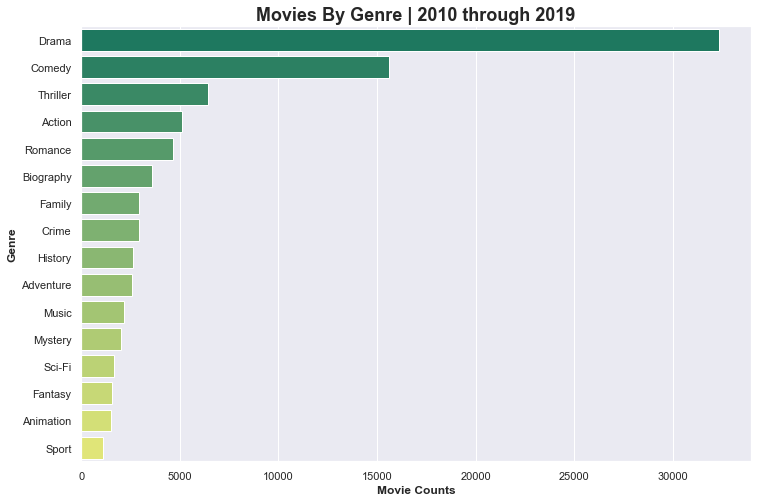

In [28]:
# Plot the top 20 genres by title count from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax = sns.barplot(data = titles_der, orient='h', x = 'movie_count', y = 'genres', palette='summer')
ax.set_title('Movies By Genre | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
plt.show()
# Possibly add cumulative % 2nd axis

### Counts By Genre Chart

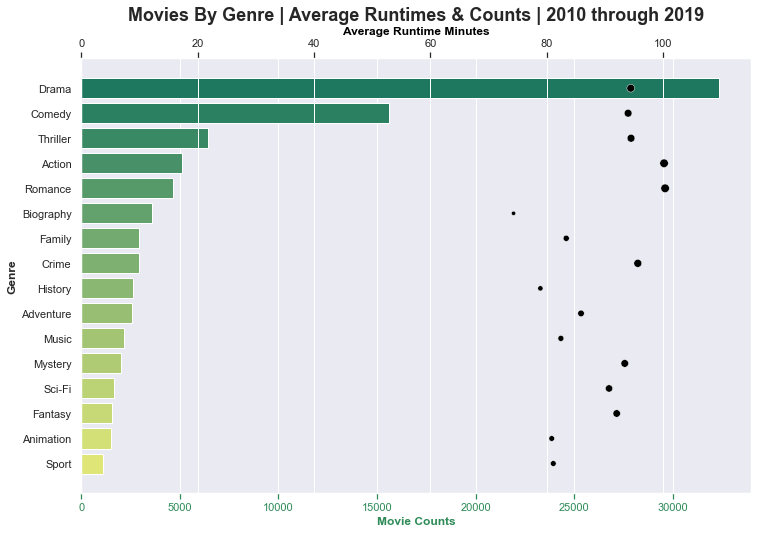

In [29]:
# Plot the top 22 genres by movie count and runtime minutes from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax_color = 'seagreen'
ax = sns.barplot(data = titles_der, orient='h', x = 'movie_count', y = 'genres', palette='summer')
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax_color) 
ax.xaxis.label.set_color(ax_color)
ax.set_xlim(0, None)
ax.tick_params(axis='x', colors=ax_color)
ax.set_title('Movies By Genre | Average Runtimes & Counts | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 

#specify we want to share the same x-axis
ax2 = ax.twiny()
ax2_color = 'black'
ax2 = sns.scatterplot(data = titles_der, x = 'avg_runtime_mins', y = 'genres', color=ax2_color, size='avg_runtime_mins', legend=False)
ax2.set_xlim(0, 115)
ax2.set_xlabel('Average Runtime Minutes', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax2_color)
plt.show()

### Ratings By Genre Chart

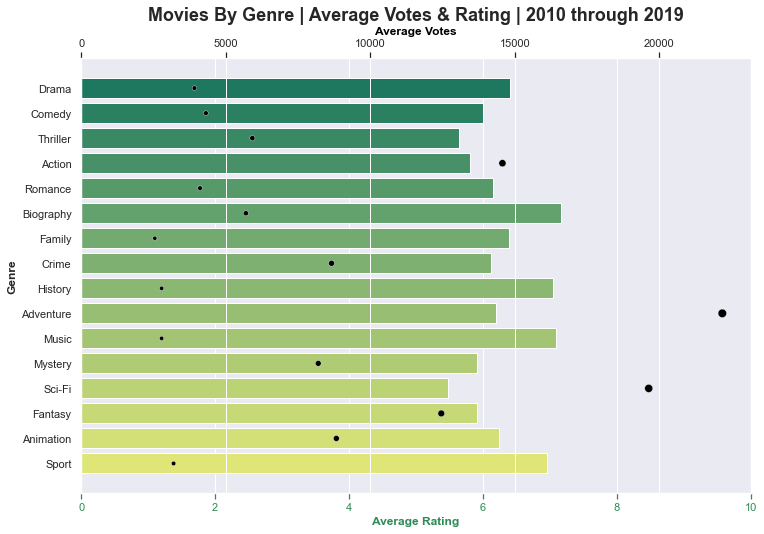

In [30]:
# Plot the top 22 genres by average movie rating and votes from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")

ax_color = 'seagreen'
ax = sns.barplot(data = titles_der, orient='h', x = 'avg_rating_avg', y = 'genres', palette='summer')
ax.set_xlabel('Average Rating', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax_color) 
ax.xaxis.label.set_color(ax_color)
ax.set_xlim(0, 10)
ax.tick_params(axis='x', colors=ax_color)
ax.set_title('Movies By Genre | Average Votes & Rating | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 

#specify we want to share the same x-axis
ax2 = ax.twiny()
ax2_color = 'black'
ax2 = sns.scatterplot(data = titles_der, x = 'num_votes_avg', y = 'genres', color=ax2_color, size='num_votes_avg', legend=False)
ax2.set_xlim(0, None)
ax2.set_xlabel('Average Votes', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax2_color)

plt.show()

## Genre Profit Correlation

In [31]:
# Convert profits columns using weighted counts
g_cnt_der['production_budget_der'] = g_cnt_der['production_budget'] / g_cnt_der['num_genres']
g_cnt_der['worldwide_gross_der'] = g_cnt_der['worldwide_gross'] / g_cnt_der['num_genres']
g_cnt_der['worldwide_profit_der'] = g_cnt_der['worldwide_profit'] / g_cnt_der['num_genres']
profits = g_cnt_der[g_cnt_der['tn_ind'] == 'both']
profits.head()
len(profits.tconst.unique())

1442

In [32]:
profits_der = profits.groupby('genres', as_index=False).agg(movie_count = ('title_cnt_der', 'sum'), avg_runtime_mins = ('runtime_minutes', 'mean'), avg_rating_avg = ('avg_rating', 'mean'), num_votes_avg = ('num_votes', 'mean')).sort_values('movie_count', ascending=False)
titles_der['total_movies'] = titles_der['movie_count'].sum()
titles_der['pct_total'] = (titles_der['movie_count']*100 / titles_der['total_movies'])
titles_der

genres  movie_count  avg_runtime_mins  avg_rating_avg  num_votes_avg  \
6       Drama    32,312.83             94.40            6.40       3,922.18   
4      Comedy    15,625.67             93.95            6.00       4,315.90   
15   Thriller     6,410.83             94.45            5.64       5,923.99   
0      Action     5,110.00            100.12            5.81      14,573.83   
12    Romance     4,664.00            100.30            6.15       4,114.67   
3   Biography     3,615.17             74.28            7.16       5,699.92   
7      Family     2,948.00             83.32            6.39       2,551.15   
5       Crime     2,915.17             95.62            6.11       8,662.39   
9     History     2,611.83             78.89            7.04       2,786.10   
1   Adventure     2,602.00             85.86            6.19      22,177.42   
10      Music     2,169.83             82.41            7.09       2,786.17   
11    Mystery     2,001.83             93.37            5.92       8,202.89   
13     Sci-Fi     1,672.17             90.68            5.49      19,632.28   
8     Fantasy     1,554.83             91.99            5.92      12,457.27   
2   Animation     1,504.50             80.83            6.25       8,828.78   
14      Sport     1,133.33             81.10            6.97       3,200.12   

    total_movies  pct_total  
6      88,852.00      36.37  
4      88,852.00      17.59  
15     88,852.00       7.22  
0      88,852.00       5.75  
12     88,852.00       5.25  
3      88,852.00       4.07  
7      88,852.00       3.32  
5      88,852.00       3.28  
9      88,852.00       2.94  
1      88,852.00       2.93  
10     88,852.00       2.44  
11     88,852.00       2.25  
13     88,852.00       1.88  
8      88,852.00       1.75  
2      88,852.00       1.69  
14     88,852.00       1.28

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


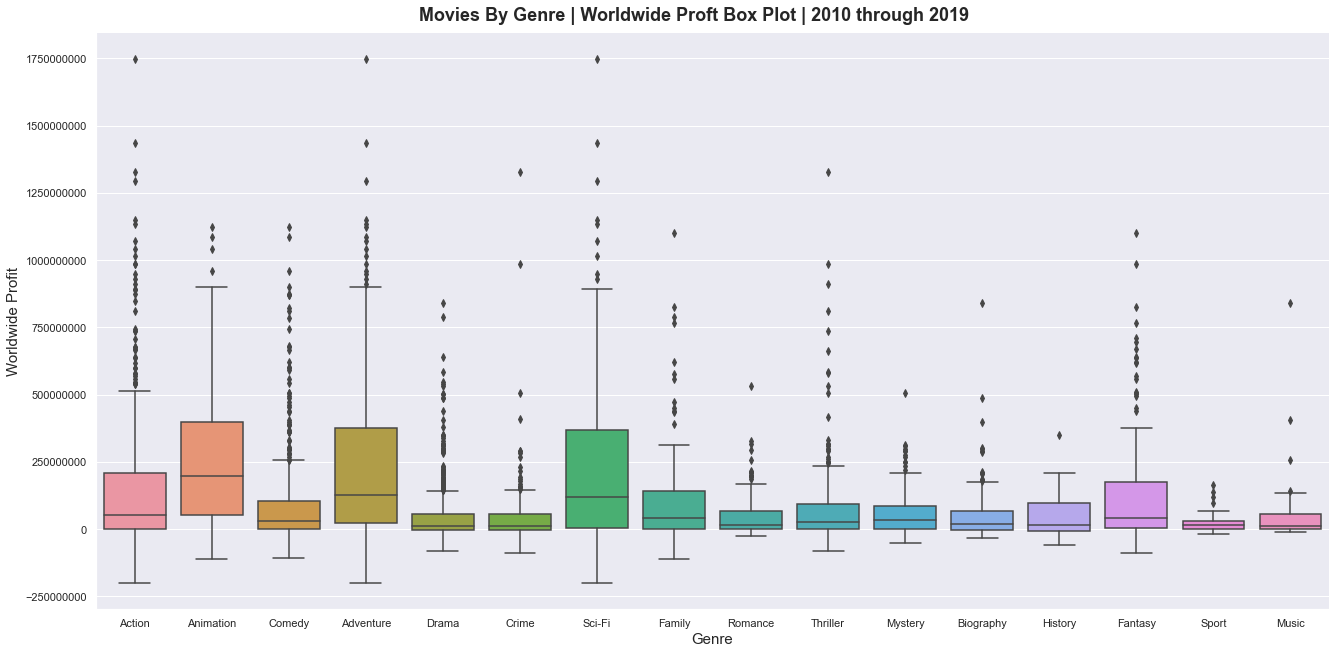

In [153]:
# plot
sns.set(style="darkgrid")
box_profit = sns.catplot(kind='box', data=profits, x="genres", y="worldwide_profit", ax=ax, height=9, aspect=2)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Worldwide Profit', fontsize=15)
plt.subplots_adjust(top=0.94)
box_profit.fig.suptitle('Movies By Genre | Worldwide Proft Box Plot | 2010 through 2019', fontsize = 18, fontweight ="bold")
plt.show()

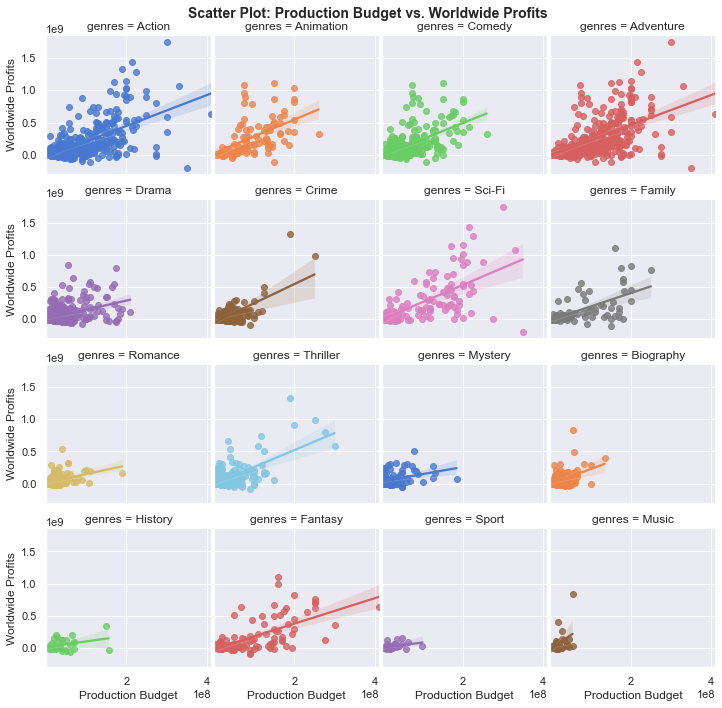

In [33]:
# plot
sns.set(style='darkgrid')
s = sns.lmplot(data=profits, x='production_budget', y='worldwide_profit', hue='genres', palette="muted", 
               height=2.5, col="genres", col_wrap=4, legend_out=True, sharey=True)
# Set title
plt.subplots_adjust(top=0.94)
s.fig.suptitle('Scatter Plot: Production Budget vs. Worldwide Profits', fontsize=14, fontweight='bold')
s.set_axis_labels('Production Budget', 'Worldwide Profits')
s.fig.subplots_adjust(wspace=.02)

## Budget Size

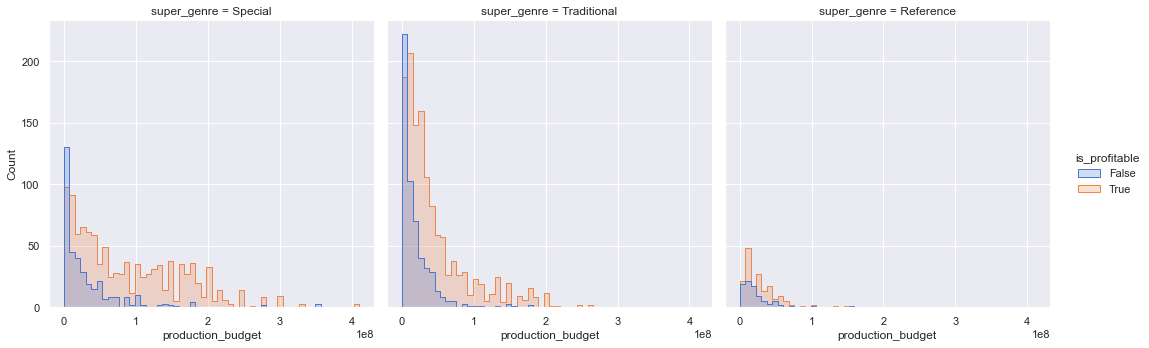

In [36]:
sns.displot(data=profits, x='production_budget', col='super_genre', hue='is_profitable', kind='hist', 
            palette='muted', element="step")

## Top Actors

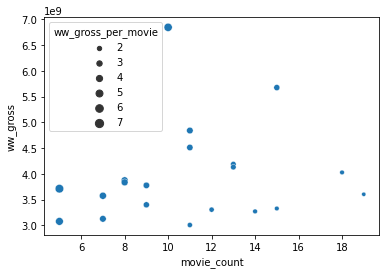

In [71]:
#f, ax = plt.subplots(figsize=(10, 10))
top20 = top[:20]
sns.scatterplot(data=top20, x="movie_count", y="ww_gross", size='ww_gross_per_movie')
plt.show()

In [69]:
top20.info

<bound method DataFrame.info of            primary_name  movie_count  domestic_gross  foreign_gross  \
3252  Robert Downey Jr.           10      2967300000     3876501370   
1025     Dwayne Johnson           15      2442400000     3232402173   
641     Chris Hemsworth           11      2164900000     2676201370   
638         Chris Evans           11      2049506100     2462601369   
1951        Johnny Depp           13      1160000000     3028000000   
2499       Mark Ruffalo           13      1860446499     2270301370   
2504      Mark Wahlberg           18      1680299999     2348200000   
3958         Vin Diesel            8      1819900000     2056302173   
656         Chris Pratt            8      1948403000     1887401019   
2357     Liam Hemsworth            9      1712000000     2065500000   
1498       Ian McKellen            5      1068099999     2644500000   
3629       Steve Carell           19      1580815200     2023704000   
2042    Josh Hutcherson            7      166

## Correlation

In [186]:
profits2 = movies[ (movies['tn_ind'] == 'both') & (movies['start_year'].between(2010,2019)) ]
profits3 = movies[ (movies['gross_ind'] == 'both') & (movies['start_year'].between(2010,2019)) ]

profit = profits2['worldwide_profit']
action = profits2['rating_sum']
result = profit.corr(action, method='pearson')
result

profits2.corr(method='pearson')


start_year  runtime_minutes  avg_rating  num_votes  \
start_year               1.00             0.13        0.03      -0.10   
runtime_minutes          0.13             1.00        0.41       0.43   
avg_rating               0.03             0.41        1.00       0.50   
num_votes               -0.10             0.43        0.50       1.00   
rating_sum              -0.09             0.42        0.51       0.99   
domestic_gross_x         0.10             0.28        0.29       0.64   
foreign_gross            0.10             0.28        0.25       0.59   
title_cnt                 nan              nan         nan        nan   
production_budget        0.06             0.37        0.23       0.55   
domestic_gross_y         0.08             0.32        0.33       0.67   
worldwide_gross          0.08             0.33        0.31       0.66   
worldwide_profit         0.08             0.29        0.31       0.64   
profit_margin            0.03            -0.03        0.02       0.08   
gross_per_rating         0.04            -0.07        0.00      -0.02   
is_action                0.06             0.17       -0.02       0.24   
is_adult                  nan              nan         nan        nan   
is_adventure             0.09             0.11        0.08       0.28   
is_animation             0.03            -0.19        0.06       0.01   
is_biography             0.11             0.18        0.22      -0.01   
is_comedy               -0.08            -0.20       -0.06      -0.11   
is_crime                 0.02             0.04        0.02      -0.01   
is_documentary          -0.06            -0.20        0.06      -0.10   
is_drama                 0.00             0.21        0.23      -0.10   
is_family               -0.05            -0.02       -0.03      -0.06   
is_fantasy               0.01             0.06       -0.05       0.06   
is_game-show              nan              nan         nan        nan   
is_history               0.08             0.15        0.10      -0.02   
is_horror                0.04            -0.20       -0.29      -0.11   
is_music                -0.01             0.03        0.01      -0.06   
is_musical              -0.02             0.04       -0.02      -0.02   
is_mystery               0.04            -0.02       -0.05       0.02   
is_news                   nan              nan         nan        nan   
is_reality-tv             nan              nan         nan        nan   
is_romance              -0.12            -0.03        0.02      -0.09   
is_sci-fi                0.06             0.13        0.05       0.30   
is_short                  nan              nan         nan        nan   
is_sport                 0.01             0.11        0.09      -0.04   
is_talk-show              nan              nan         nan        nan   
is_thriller             -0.01            -0.05       -0.13       0.01   
is_war                  -0.01             0.08        0.03      -0.03   
is_western              -0.04             0.04        0.00       0.03   

                   rating_sum  domestic_gross_x  foreign_gross  title_cnt  \
start_year              -0.09              0.10           0.10        nan   
runtime_minutes          0.42              0.28           0.28        nan   
avg_rating               0.51              0.29           0.25        nan   
num_votes                0.99              0.64           0.59        nan   
rating_sum               1.00              0.61           0.56        nan   
domestic_gross_x         0.61              1.00           0.80        nan   
foreign_gross            0.56              0.80           1.00        nan   
title_cnt                 nan               nan            nan        nan   
production_budget        0.51              0.69           0.76        nan   
domestic_gross_y         0.64              1.00           0.80        nan   
worldwide_gross          0.63              0.94           0.90        nan   
worldwide_profit         0.6

In [ ]:
profits.info()

# Appendix

In [ ]:
tip_rate = tips.eval("tip / total_bill").rename("tip_rate")

## Deprecated Code

In [ ]:
# IMDB Basics parse and featurize genres
def match_genre(target_genre, title_genres):
    result = 0
    if title_genres: 
        for genre in title_genres:
            if genre == target_genre: 
                result += 1
            else:     
                result += 0
    if result > 0: result = 1
    return result

unique_genres = sorted(imdb_basics['genres'].str.split(pat=",").explode().dropna().unique())
genre_series = imdb_basics['genres'].str.split(pat=",")

for key, genre in genre_series.head(50).items():
    for g in unique_genres:
        match = match_genre(g, genre)
        #print(genre, g, match)
        genre_series[key][g] = match #old method, had error on this line otherwise function working

imdb_basics.head(50)